<a href="https://colab.research.google.com/github/kurikinton105/GDL_code_colab/blob/main/06_02_qa_train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ドライブのマウントを行い、ディレクトリを移動する**

データをdata/qa/に配置する

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/GDL

/content/drive/MyDrive/Colab Notebooks/GDL


# Generating question answer pairs from text

In [ ]:
import importlib
import os

from tensorflow.keras.layers import Input, Embedding, GRU, Bidirectional, Dense, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from tensorflow.keras.utils import plot_model

import numpy as np
import random
import pickle as pkl

from utils.write import training_data, test_data, collapse_documents, expand_answers, _read_data, glove

import matplotlib.pyplot as plt

In [ ]:
# run params
SECTION = 'write'
RUN_ID = '0001'
DATA_NAME = 'qa'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

# data

In [ ]:

training_data_gen = training_data()
# training_data_gen = [next(training_data_gen)]
test_data_gen = test_data()


In [ ]:
t = next(training_data_gen)

In [ ]:
idx = 0

print('document_tokens\n', t['document_tokens'][idx])
print('\n')
print('question_input_tokens\n', t['question_input_tokens'][idx])
print('\n')
print('answer_masks\n', t['answer_masks'][idx])
print('\n')
print('answer_labels\n', t['answer_labels'][idx])
print('\n')
print('question_output_tokens\n', t['question_output_tokens'][idx])

document_tokens
 [   1 4633    1   66  285    1    1 5115 1420   60    4 1136 1952    8
  852  316  287   10    4  122   16  183    8   89 1090   60   72  558
    8  361    8    1    4  283  122    6 6413 7338 4861   11 7656   16
   27 1240   26  852  115    8 3356    5 2387    5   16  183    6   29
   42  471   10  218  359    5   28   19 5115    5   39   17 3281    8
    4 2694  935  852 7860    9 1136    1   26   72  163   10    1    5
 6312    6   29   42  471   11 1112    1    5  100   42  767  241 5180
    6   28   10  892    7    4 7391 2621    5    4   99   93  357    9
    4 2709   13 1280  423    9 4488 1095   11 1952   98  130    1 1136
    8  852    6    4  482   95 4051    1   30  410 3001 2426  458   10
    4  123    6    4   86  359  732 1419  251   37    8    1  146 1136
   47  382 2944    5   22  125 1175   55   37   10  994 4221    4 3773
    6  676    8 3475    4 3773   24    1 1136   55   31 2948    8  161
  295   29    1 1175    5   28   19 1332    1    1    5    4

In [ ]:
# GloVe

VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

print('GLOVE')
print('VOCAB_SIZE: ', VOCAB_SIZE)
print('EMBEDDING_DIMENS: ', EMBEDDING_DIMENS)

GRU_UNITS = 100


GLOVE
VOCAB_SIZE:  9984
EMBEDDING_DIMENS:  100


# parameters

In [ ]:
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

# architecture

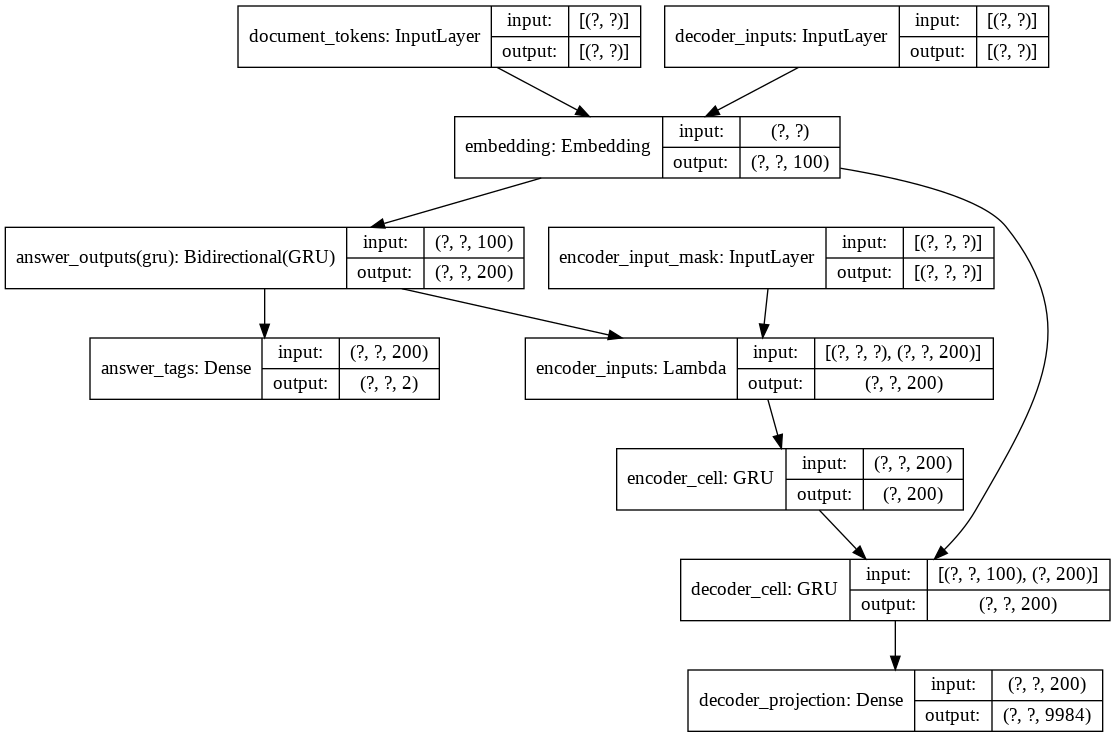

In [ ]:
document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(2, activation = 'softmax', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax', use_bias = False)
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file='model.png',show_shapes=True)

In [ ]:
decoder_emb.shape

TensorShape([None, None, 100])

In [ ]:
answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])

In [ ]:
total_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
document_tokens (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    998400      document_tokens[0][0]            
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
answer_outputs (Bidirectional)  (None, None, 200)    121200      embedding[0][0]                  
__________________________________________________________________________________________________
encoder_input_mask (InputLayer) [(None, None, None)] 0                                 

In [ ]:
#### INFERENCE MODEL ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])



In [ ]:
#### COMPILE TRAINING MODEL ####

opti = Adam(lr=0.001)
total_model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy']
                    , optimizer=opti
                    , loss_weights = [1,1]) 


# train

In [ ]:
training_loss_history = []
test_loss_history = []

EPOCHS = 3
start_epoch = 1

In [ ]:
for epoch in range(start_epoch, start_epoch + EPOCHS + 1):
    print("Epoch {0}".format(epoch))
    
    for i, batch in enumerate(training_data()):
        
        val_batch = next(test_data_gen, None)
        
        if val_batch is None:
            test_data_gen = test_data()
            val_batch = next(test_data_gen, None)
            
        training_loss = total_model.train_on_batch(
            [batch['document_tokens'], batch['question_input_tokens'], batch['answer_masks']]
            , [np.expand_dims(batch['answer_labels'], axis = -1), np.expand_dims(batch['question_output_tokens'], axis = -1)]
        )
        
        test_loss = total_model.test_on_batch(
            [val_batch['document_tokens'], val_batch['question_input_tokens'], val_batch['answer_masks']]
            , [np.expand_dims(val_batch['answer_labels'], axis = -1), np.expand_dims(val_batch['question_output_tokens'], axis = -1)]
        )
        
        training_loss_history.append(training_loss)
        test_loss_history.append(test_loss)
        
        print("{}: Train Loss: {} | Test Loss: {}".format(i, training_loss, test_loss))
        
        total_model.save_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(epoch)))
        

Epoch 1
0: Train Loss: [2.4305832386016846, 0.31344175338745117, 2.1171412467956543] | Test Loss: [4.013306617736816, 0.20902468264102936, 3.8042819499969482]
1: Train Loss: [2.293238878250122, 0.29070138931274414, 2.002537488937378] | Test Loss: [4.005984783172607, 0.20907878875732422, 3.796905994415283]
2: Train Loss: [2.450779676437378, 0.4104864299297333, 2.0402932167053223] | Test Loss: [4.008505344390869, 0.21342089772224426, 3.7950844764709473]
3: Train Loss: [2.324796438217163, 0.251020222902298, 2.0737762451171875] | Test Loss: [4.009485244750977, 0.2158113718032837, 3.7936739921569824]
4: Train Loss: [2.6023433208465576, 0.2926391065120697, 2.309704303741455] | Test Loss: [4.006556510925293, 0.21609294414520264, 3.79046368598938]
5: Train Loss: [1.3628567457199097, 0.32056018710136414, 1.0422966480255127] | Test Loss: [4.003810405731201, 0.2151477038860321, 3.7886626720428467]
6: Train Loss: [2.640296459197998, 0.3432840406894684, 2.2970123291015625] | Test Loss: [4.010798931

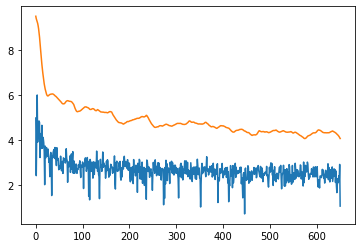

In [ ]:
#### SHOW LOSSES ####

plt.plot(np.array(training_loss_history)[:,0])
plt.plot(np.array(test_loss_history)[:,0])
plt.show()
        
pkl.dump([training_loss_history, test_loss_history], open(os.path.join(RUN_FOLDER, 'weights/histories.pkl'), 'wb'))

In [ ]:
print(tf.__version__)